In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import torch
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

KERNEL_SIZE = 3
LEARNING_RATE = 0.0005
IMG_SIZE = 28 
training_data = []

C:\Users\miste\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU run.")
else:
    device = torch.device("cpu")
    print("CPU run.")

wandb.config = {
}
wandb.init(project="mnist-conv")

GPU run.


wandb: Currently logged in as: lindlaaa. Use `wandb login --relogin` to force relogin


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
        
net = CNN().to(device)
wandb.watch(net)

optimizer = optim.Adam(params=net.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

print(net)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)


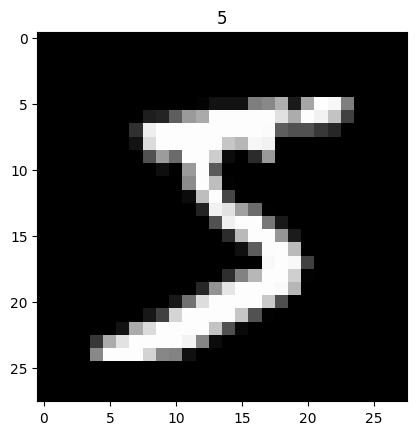

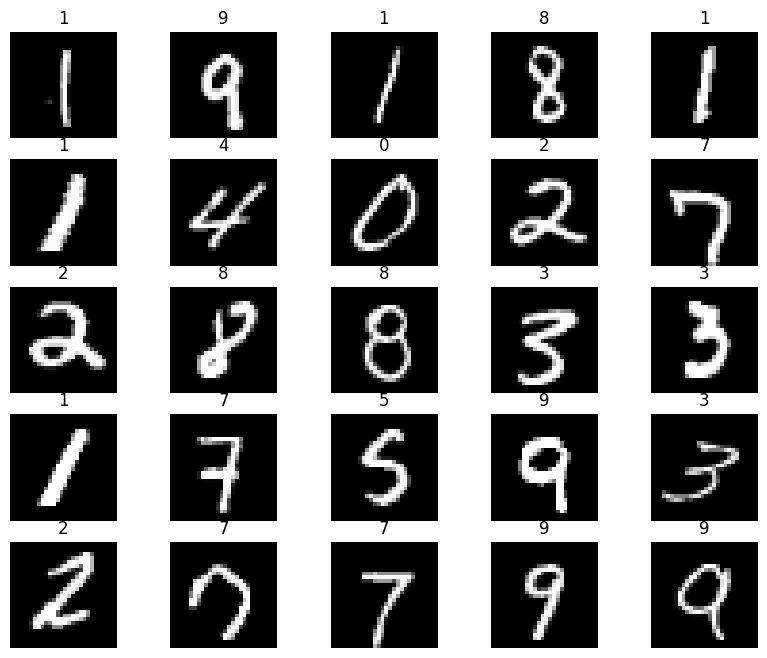

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x236303f0250>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2362ecdc3d0>}

In [7]:
def test(size=len(loaders['test'])):
    # Test the model
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        i = 0
        for images, labels in loaders['test']:
            i += 1
            images = images.to(device)
            labels = labels.to(device)
            test_output, last_layer = net(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            if i >= size:
                print(i)
                break
            pass
        print(i)
        return accuracy

In [8]:
from torch.autograd import Variable
num_epochs = 10

def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in tqdm(range(num_epochs)):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device)   # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = cnn(b_x)[0].to(device)
            loss = loss_function(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                eval_acc = test(size=10)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, eval_acc: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), eval_acc))
                wandb.log({
                    'eval_acc': eval_acc,
                    'loss': loss.item(),
                    'epoch': epoch+1,
                    'batch': i + 1}
                )
                pass
        accuracy = test()
        print ('Epoch [{}/{}], eval_acc: {:.4f}' 
                       .format(epoch + 1, num_epochs, eval_acc))
        wandb.log({
                    'accuracy': accuracy
        })
        pass
    pass
train(num_epochs, net, loaders)

  0%|                                                                                                         | 0/10 [00:00<?, ?it/s]

10
10
Epoch [1/10], Step [100/600], Loss: 0.4811, eval_acc: 0.8500
10
10
Epoch [1/10], Step [200/600], Loss: 0.1650, eval_acc: 0.9400
10
10
Epoch [1/10], Step [300/600], Loss: 0.2568, eval_acc: 0.9600
10
10
Epoch [1/10], Step [400/600], Loss: 0.1153, eval_acc: 0.9600
10
10
Epoch [1/10], Step [500/600], Loss: 0.1128, eval_acc: 1.0000
10
10
Epoch [1/10], Step [600/600], Loss: 0.1715, eval_acc: 0.9900


 10%|█████████▋                                                                                       | 1/10 [00:23<03:32, 23.62s/it]

100
100
Epoch [1/10], eval_acc: 0.9900
10
10
Epoch [2/10], Step [100/600], Loss: 0.0769, eval_acc: 0.9400
10
10
Epoch [2/10], Step [200/600], Loss: 0.1193, eval_acc: 0.9900
10
10
Epoch [2/10], Step [300/600], Loss: 0.0440, eval_acc: 1.0000
10
10
Epoch [2/10], Step [400/600], Loss: 0.0922, eval_acc: 0.9800
10
10
Epoch [2/10], Step [500/600], Loss: 0.1275, eval_acc: 0.9800
10
10
Epoch [2/10], Step [600/600], Loss: 0.0626, eval_acc: 0.9700


 20%|███████████████████▍                                                                             | 2/10 [00:44<02:57, 22.15s/it]

100
100
Epoch [2/10], eval_acc: 0.9700
10
10
Epoch [3/10], Step [100/600], Loss: 0.1265, eval_acc: 1.0000
10
10
Epoch [3/10], Step [200/600], Loss: 0.0215, eval_acc: 0.9700
10
10
Epoch [3/10], Step [300/600], Loss: 0.0478, eval_acc: 0.9900
10
10
Epoch [3/10], Step [400/600], Loss: 0.0580, eval_acc: 1.0000
10
10
Epoch [3/10], Step [500/600], Loss: 0.0711, eval_acc: 0.9900
10
10
Epoch [3/10], Step [600/600], Loss: 0.0523, eval_acc: 1.0000


 30%|█████████████████████████████                                                                    | 3/10 [01:05<02:32, 21.74s/it]

100
100
Epoch [3/10], eval_acc: 1.0000
10
10
Epoch [4/10], Step [100/600], Loss: 0.0359, eval_acc: 0.9800
10
10
Epoch [4/10], Step [200/600], Loss: 0.0204, eval_acc: 0.9900
10
10
Epoch [4/10], Step [300/600], Loss: 0.0985, eval_acc: 0.9600
10
10
Epoch [4/10], Step [400/600], Loss: 0.0708, eval_acc: 0.9900
10
10
Epoch [4/10], Step [500/600], Loss: 0.0146, eval_acc: 0.9600
10
10
Epoch [4/10], Step [600/600], Loss: 0.0219, eval_acc: 0.9900


 40%|██████████████████████████████████████▊                                                          | 4/10 [01:27<02:09, 21.52s/it]

100
100
Epoch [4/10], eval_acc: 0.9900
10
10
Epoch [5/10], Step [100/600], Loss: 0.1039, eval_acc: 0.9900
10
10
Epoch [5/10], Step [200/600], Loss: 0.0265, eval_acc: 1.0000
10
10
Epoch [5/10], Step [300/600], Loss: 0.0090, eval_acc: 0.9800
10
10
Epoch [5/10], Step [400/600], Loss: 0.0298, eval_acc: 1.0000
10
10
Epoch [5/10], Step [500/600], Loss: 0.0896, eval_acc: 0.9700
10
10
Epoch [5/10], Step [600/600], Loss: 0.0186, eval_acc: 1.0000


 50%|████████████████████████████████████████████████▌                                                | 5/10 [01:48<01:46, 21.36s/it]

100
100
Epoch [5/10], eval_acc: 1.0000
10
10
Epoch [6/10], Step [100/600], Loss: 0.0039, eval_acc: 1.0000
10
10
Epoch [6/10], Step [200/600], Loss: 0.0098, eval_acc: 1.0000
10
10
Epoch [6/10], Step [300/600], Loss: 0.0696, eval_acc: 0.9700
10
10
Epoch [6/10], Step [400/600], Loss: 0.0236, eval_acc: 1.0000
10
10
Epoch [6/10], Step [500/600], Loss: 0.0242, eval_acc: 0.9800
10
10
Epoch [6/10], Step [600/600], Loss: 0.0195, eval_acc: 1.0000


 60%|██████████████████████████████████████████████████████████▏                                      | 6/10 [02:09<01:25, 21.29s/it]

100
100
Epoch [6/10], eval_acc: 1.0000
10
10
Epoch [7/10], Step [100/600], Loss: 0.0152, eval_acc: 0.9700
10
10
Epoch [7/10], Step [200/600], Loss: 0.0713, eval_acc: 1.0000
10
10
Epoch [7/10], Step [300/600], Loss: 0.1127, eval_acc: 0.9900
10
10
Epoch [7/10], Step [400/600], Loss: 0.0453, eval_acc: 0.9700
10
10
Epoch [7/10], Step [500/600], Loss: 0.0206, eval_acc: 1.0000
10
10
Epoch [7/10], Step [600/600], Loss: 0.0106, eval_acc: 0.9900


 70%|███████████████████████████████████████████████████████████████████▉                             | 7/10 [02:30<01:03, 21.24s/it]

100
100
Epoch [7/10], eval_acc: 0.9900
10
10
Epoch [8/10], Step [100/600], Loss: 0.0205, eval_acc: 1.0000
10
10
Epoch [8/10], Step [200/600], Loss: 0.0045, eval_acc: 1.0000
10
10
Epoch [8/10], Step [300/600], Loss: 0.1350, eval_acc: 0.9900
10
10
Epoch [8/10], Step [400/600], Loss: 0.0640, eval_acc: 1.0000
10
10
Epoch [8/10], Step [500/600], Loss: 0.0036, eval_acc: 0.9700
10
10
Epoch [8/10], Step [600/600], Loss: 0.0878, eval_acc: 1.0000


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 8/10 [02:51<00:42, 21.21s/it]

100
100
Epoch [8/10], eval_acc: 1.0000
10
10
Epoch [9/10], Step [100/600], Loss: 0.0403, eval_acc: 1.0000
10
10
Epoch [9/10], Step [200/600], Loss: 0.0338, eval_acc: 0.9900
10
10
Epoch [9/10], Step [300/600], Loss: 0.1044, eval_acc: 0.9700
10
10
Epoch [9/10], Step [400/600], Loss: 0.0268, eval_acc: 0.9900
10
10
Epoch [9/10], Step [500/600], Loss: 0.0017, eval_acc: 1.0000
10
10
Epoch [9/10], Step [600/600], Loss: 0.0325, eval_acc: 1.0000


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 9/10 [03:12<00:21, 21.17s/it]

100
100
Epoch [9/10], eval_acc: 1.0000
10
10
Epoch [10/10], Step [100/600], Loss: 0.0084, eval_acc: 0.9900
10
10
Epoch [10/10], Step [200/600], Loss: 0.0200, eval_acc: 0.9900
10
10
Epoch [10/10], Step [300/600], Loss: 0.0087, eval_acc: 1.0000
10
10
Epoch [10/10], Step [400/600], Loss: 0.0098, eval_acc: 1.0000
10
10
Epoch [10/10], Step [500/600], Loss: 0.0062, eval_acc: 1.0000
10
10
Epoch [10/10], Step [600/600], Loss: 0.0084, eval_acc: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.39s/it]

100
100
Epoch [10/10], eval_acc: 1.0000


In [9]:
wandb.finish()

accuracy,▅▁▆██▆█▅▆▅
batch,▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅▇▁▂▅█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
eval_acc,▁▅▆█▅█▇▇█▇██▇██▆███▇███▇▇█▇████▇████████
loss,█▃▃▃▂▃▂▃▃▁▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁
accuracy,0.98
batch,600
epoch,10
eval_acc,1.0
loss,0.0084
